<a href="https://colab.research.google.com/github/amanteur/MLDM_KaggleProject/blob/main/MLDM_project_explanatory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import random

%matplotlib inline
sns.set(style='white')

In [2]:
# PATHS
PATH = '/content/drive/MyDrive/datasets/kaggle_musrec/preprocessed/'
FEATURES_PATHS = {'train': 'train_expanded_result.csv',
                  'test': 'test_expanded_result.csv'}

In [3]:
train = pd.read_csv(PATH + FEATURES_PATHS['train'])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,23,24,25,26,27,29) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# need to cast right type!
train.iloc[0, [21,23,24,25,26,27,29]]

language                52
song_length_cat          1
artist_name_number       1
composer_number          2
lyricist_number          0
genre_number             1
decade                2010
Name: 0, dtype: object

In [50]:
def preprocess(df):
  # language
  df['language'] = df['language'].apply(str)
  # song_length_cat
  df['song_length_cat'] = df['song_length_cat'].apply(str)
  # artist_name_number 
  df["artist_name_number"].replace({"UNKNOWN": np.nan}, inplace=True)
  df['artist_name_number'] = df['artist_name_number'].apply(float).clip(upper=4)
  # composer_number
  df["composer_number"].replace({"UNKNOWN": np.nan}, inplace=True)
  df['composer_number'] = df['composer_number'].apply(float).clip(upper=6)
  # lyricist number
  df["lyricist_number"].replace({"UNKNOWN": np.nan}, inplace=True)
  df['lyricist_number'] = df['lyricist_number'].apply(float).clip(upper=4)
  # genre_number
  df["genre_number"].replace({"UNKNOWN": np.nan}, inplace=True)
  df['genre_number'] = df['genre_number'].apply(float).clip(upper=3)
  # decade
  df['decade'] = df['decade'].apply(str)
  return df

## Supplementary functions

In [18]:
def plot_pie_chart(df: pd.DataFrame, 
                   column: str, 
                   thr: float = .50,
                   agg_func: str = 'count') -> List:
  # Warning handling
  pd.options.mode.chained_assignment = None  # default='warn'

  # make new row with values lower than percentile
  df_grouped = df.groupby(column).agg(counter=pd.NamedAgg(column=column, 
                                                            aggfunc=agg_func))
  df_grouped_pct = df_grouped.apply(lambda x: 100 * x/x.sum())

  if thr == 0:
    plot_dict = df_grouped_pct.sort_values(by='counter').to_dict()['counter']
  else:
    threshold = df_grouped_pct.quantile(thr).values[0]
    df_grouped_pct_thr = df_grouped_pct[df_grouped_pct['counter'] > threshold]
    other = df_grouped_pct.loc[df_grouped_pct['counter'] <= threshold, 'counter']
    df_grouped_pct_thr.loc['other'] = other.sum()
    plot_dict = df_grouped_pct_thr.sort_values(by='counter').to_dict()['counter']

  colors = sns.color_palette('pastel')[0:len(plot_dict)]

  plt.pie(plot_dict.values(), 
          labels = plot_dict.keys(), 
          colors = colors, 
          autopct='%.0f%%',
          explode=[0.01]*len(plot_dict),
          pctdistance=0.5,
          radius=100)
  plt.axis('equal')
  plt.tight_layout()
  plt.show()
  if thr != 0:
    return other.index.to_list()
  else:
    return []

In [78]:
def plot_bar_chart(df: pd.DataFrame, 
                   col: str, 
                   unique_col: List[str], 
                   x_lab: str, 
                   y_lab: str,
                   drop_dups: bool=True) -> None:
  if drop_dups:
    df_unq = df.drop_duplicates(unique_col)[col]
  else:
    df_unq = df[col]
  if 'ratio' in col:
    df_unq = df_unq * 100
  min_val = df_unq.min()
  max_val = df_unq.max()
  if min_val == 0:
    min_val += 1
  # plotting
  colors = sns.color_palette('pastel')
  length_bins = np.logspace(np.log10(min_val),np.log10(max_val+1),50)
  sns.displot(df_unq, 
              bins=length_bins, 
              kde=False, 
              height=5, 
              aspect=2, 
              shrink=0.5,
              color=colors[0])
  plt.axvline(df_unq.median(), 
              c=colors[1], 
              ls='--', 
              lw=2.5, 
              label='Median')
  plt.axvline(df_unq.mean(), 
              c=colors[6], 
              ls='-', 
              lw=2.5, 
              label='Mean')
  plt.title('Median = {:.1f}, Mean = {:.1f}'.format(df_unq.median(),
                                                    df_unq.mean()))
  plt.xlabel(x_lab)
  plt.ylabel(y_lab)
  plt.yscale('log')
  plt.xscale('log')
  plt.legend()
  plt.show()

Let us inspect all columns in train. 

In [5]:
train.columns

Index(['msno', 'song_id', 'source_system_tab', 'source_screen_name',
       'source_type', 'target', 'user_plays', 'song_plays', 'user_repeats',
       'song_repeats', 'user_repeat_ratio', 'song_repeat_ratio', 'city', 'bd',
       'gender', 'registered_via', 'membership_days', 'got_bd', 'artist_name',
       'composer', 'lyricist', 'language', 'genre_ids', 'song_length_cat',
       'artist_name_number', 'composer_number', 'lyricist_number',
       'genre_number', 'name', 'decade', 'country', 'genre_first',
       'genre_first_ratio', 'country_ratio', 'language_ratio',
       'source_type_ratio', 'source_system_tab_ratio', 'song_length_cat_ratio',
       'decade_ratio', 'artist_name_ratio', 'composer_ratio',
       'lyricist_ratio'],
      dtype='object')

Let us go in order of these columns

## MSNO

In [14]:
# number of unique users in train and test
train.msno.unique().shape, test.msno.unique().shape

((30755,), (25131,))

## Song_ID


In [15]:
# number of unique songs in train and test
train.song_id.unique().shape, test.song_id.unique().shape

((359966,), (224753,))

## Source system tab

In [22]:
# unique source system tabs
train.source_system_tab.unique()

array(['explore', 'my library', 'search', 'discover', 'unknown', 'radio',
       'listen with', 'notification', 'settings'], dtype=object)

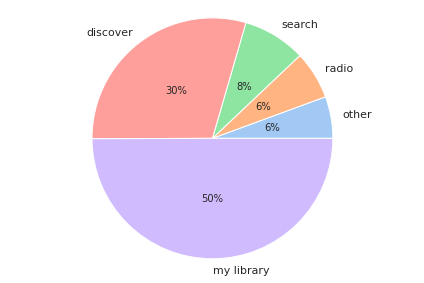

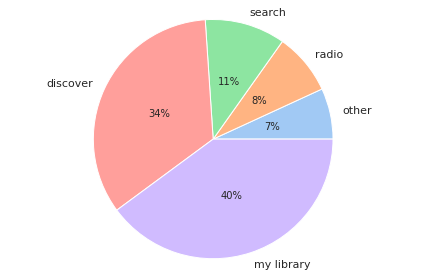

(['explore', 'listen with', 'notification', 'settings', 'unknown'],
 ['explore', 'listen with', 'notification', 'settings', 'unknown'])

In [49]:
plot_pie_chart(train, 'source_system_tab'), plot_pie_chart(test, 'source_system_tab')

## Source screen name

In [21]:
train.source_screen_name.unique()

array(['explore', 'local playlist more', 'unknown', 'my library',
       'online playlist more', 'album more', 'discover feature',
       'discover chart', 'radio', 'artist more', 'search',
       'others profile more', 'search trends', 'discover genre',
       'my library_search', 'search home', 'discover new',
       'self profile more', 'concert', 'payment'], dtype=object)

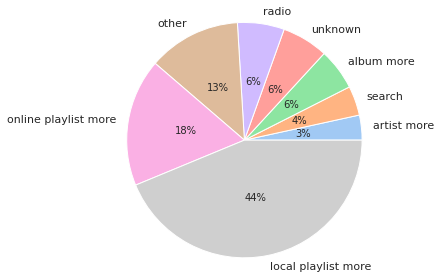

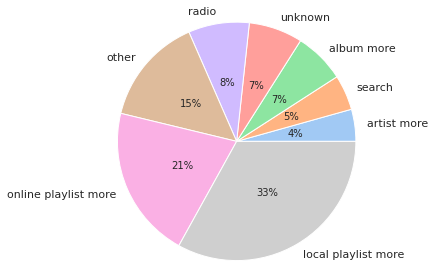

(['concert',
  'discover chart',
  'discover feature',
  'discover genre',
  'discover new',
  'explore',
  'my library',
  'my library_search',
  'others profile more',
  'payment',
  'search home',
  'search trends',
  'self profile more'],
 ['concert',
  'discover chart',
  'discover feature',
  'discover genre',
  'discover new',
  'explore',
  'my library',
  'my library_search',
  'others profile more',
  'payment',
  'search home',
  'search trends',
  'self profile more'])

In [48]:
plot_pie_chart(train, 'source_screen_name', thr=0.65), plot_pie_chart(test, 'source_screen_name', thr=0.65) 

## Source type

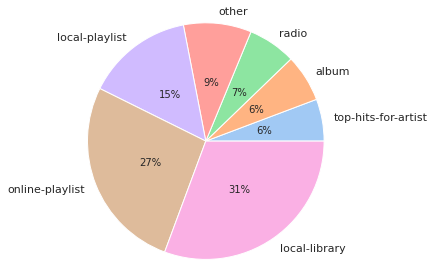

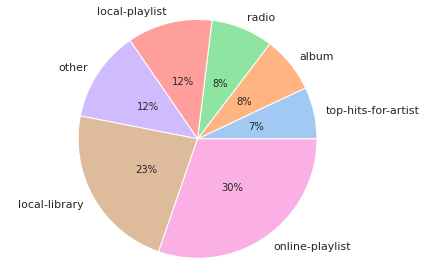

(['artist',
  'listen-with',
  'my-daily-playlist',
  'song',
  'song-based-playlist',
  'topic-article-playlist',
  'unknown'],
 ['artist',
  'listen-with',
  'my-daily-playlist',
  'song',
  'song-based-playlist',
  'topic-article-playlist',
  'unknown'])

In [47]:
plot_pie_chart(train, 'source_type', thr=0.50), plot_pie_chart(test, 'source_type', thr=0.50)

## user plays and replays

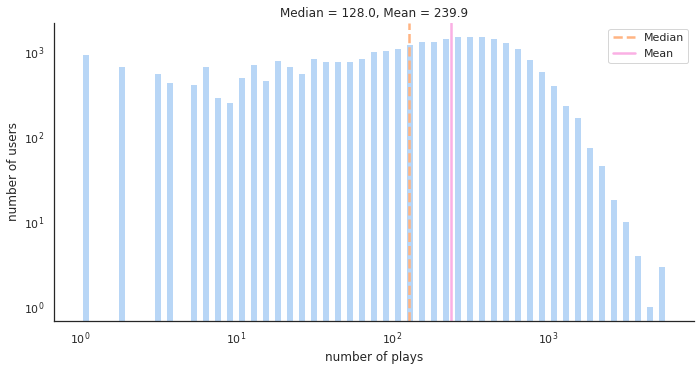

In [200]:
plot_bar_chart(train, 'user_plays', ['msno'], 'number of plays', 'number of users')

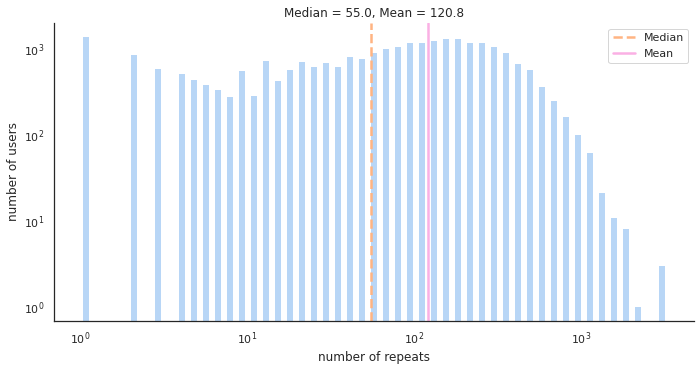

In [201]:
plot_bar_chart(train, 'user_repeats', ['msno'], 'number of repeats', 'number of users')

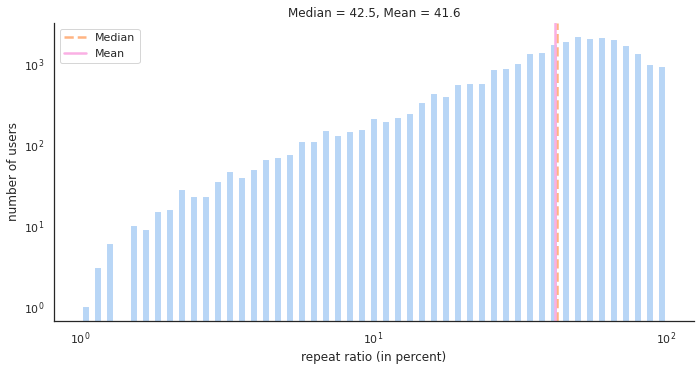

In [203]:
plot_bar_chart(train, 'user_repeat_ratio', ['msno'], 'repeat ratio (in percent)', 'number of users')

## Song plays and repeats

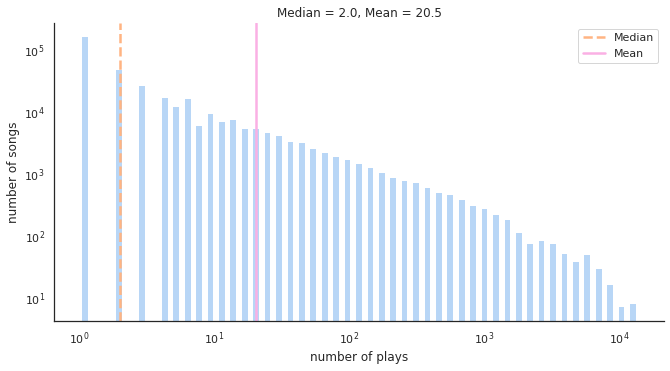

In [204]:
plot_bar_chart(train, 'song_plays', ['song_id'], 'number of plays', 'number of songs')

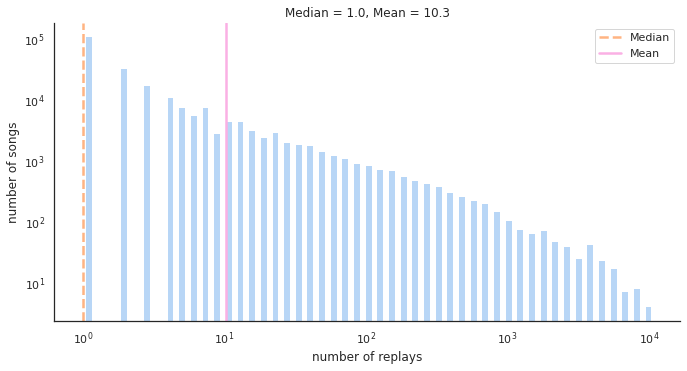

In [208]:
plot_bar_chart(train, 'song_repeats', ['song_id'], 'number of replays', 'number of songs')

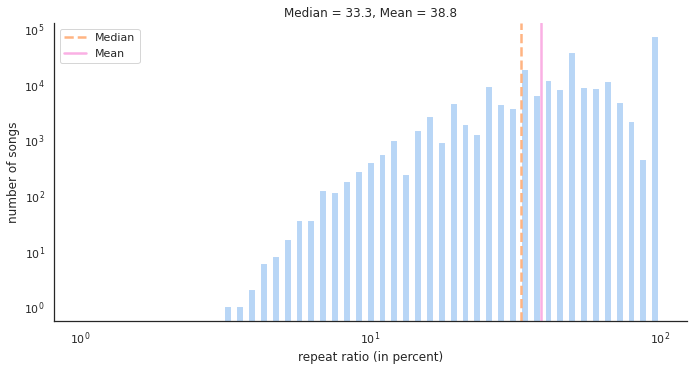

In [209]:
plot_bar_chart(train, 'song_repeat_ratio', ['song_id'], 'repeat ratio (in percent)', 'number of songs')

## User data

In [211]:
train.city.unique()

array([ 1, 13, 15,  5,  9, 21, 22, 12,  4,  6, 14, 17, 10,  8, 11, 18,  3,
        7, 20, 16, 19])

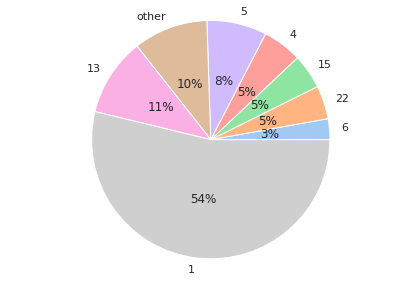

[3, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21]

In [215]:
plot_pie_chart(train.drop_duplicates('msno'), 'city', thr=0.65)
# most possible city is Taipei

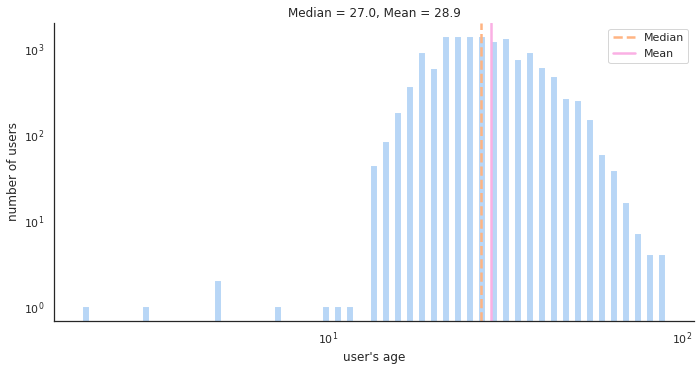

In [218]:
# only who typed their age
plot_bar_chart(train[train['got_bd']==1], 'bd', ['msno'], 'user\'s age', 'number of users')

In [228]:
train.drop_duplicates('msno').groupby('gender').count()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,user_plays,song_plays,user_repeats,song_repeats,user_repeat_ratio,song_repeat_ratio,city,bd,registered_via,membership_days,got_bd,artist_name,composer,lyricist,language,genre_ids,song_length_cat,artist_name_number,composer_number,lyricist_number,genre_number,name,decade,country,genre_first,genre_first_ratio,country_ratio,language_ratio,source_type_ratio,source_system_tab_ratio,song_length_cat_ratio,decade_ratio,artist_name_ratio,composer_ratio,lyricist_ratio
gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659,6659
1.0,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004,7004
2.0,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092,17092


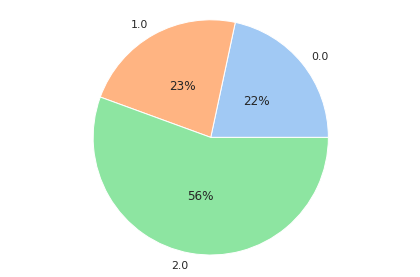

[]

In [236]:
plot_pie_chart(train.drop_duplicates('msno'), 'gender', thr=0.0)

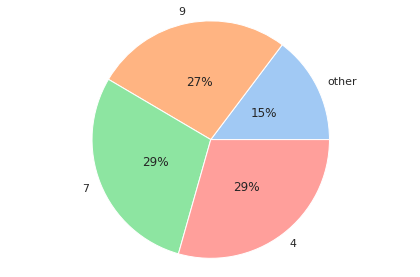

[3, 13]

In [244]:
plot_pie_chart(train.drop_duplicates('msno'), 'registered_via', thr=0.3)

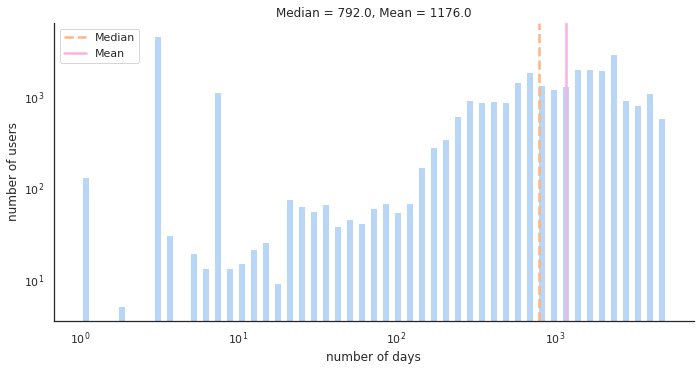

In [245]:
plot_bar_chart(train, 'membership_days', ['msno'], 'number of days', 'number of users')

## Song Data

language

In [8]:
train.language.unique()

array(['52.0', '-1.0', '31.0', '3.0', '17.0', '10.0', '24.0', '59.0',
       '45.0', 'UNKNOWN', '38.0'], dtype=object)

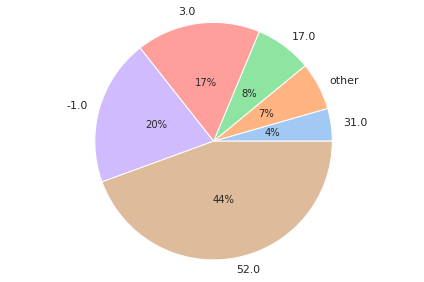

['10.0', '24.0', '38.0', '45.0', '59.0', 'UNKNOWN']

In [64]:
plot_pie_chart(train.drop_duplicates('song_id'), 'language', thr=0.50)

song length cat

In [22]:
train.song_length_cat.unique()

array(['1.0', '0.0', '2.0', '3.0', '5.0', '4.0', 'UNKNOWN'], dtype=object)

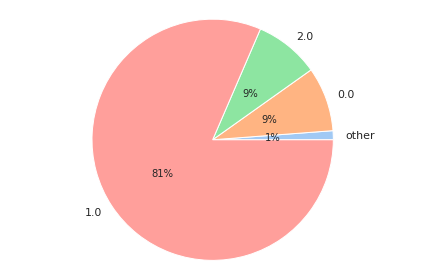

['3.0', '4.0', '5.0', 'UNKNOWN']

In [62]:
plot_pie_chart(train.drop_duplicates('song_id'), 'song_length_cat', thr=0.5)

artist name number

In [14]:
train.groupby('artist_name_number')['artist_name_number'].count().sort_values(ascending=False)

artist_name_number
1.0    7308191
2.0      54966
3.0      11785
4.0       2362
Name: artist_name_number, dtype: int64

composer number

In [25]:
train.composer_number.unique()

array([ 2.,  0.,  1.,  3.,  5.,  4., 19., 14.,  7.,  9.,  6., 11., 10.,
        8., 12., 20., 17., nan, 13., 16., 15., 18., 21., 23., 22., 51.])

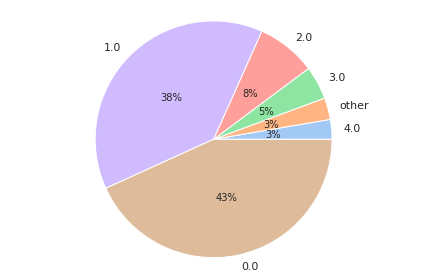

[5.0, 6.0]

In [58]:
plot_pie_chart(train.drop_duplicates('song_id'), 'composer_number', 0.25)

lyricist number

In [36]:
train.lyricist_number.unique()

array([ 0.,  2.,  1.,  5.,  3.,  6.,  7.,  4.,  9., 11.,  8., 10., 20.,
       12., nan, 14., 16., 18., 23., 13., 15., 17., 19., 21.])

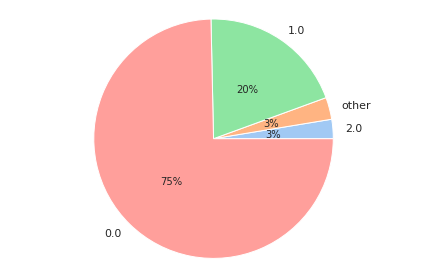

[3.0, 4.0]

In [55]:
plot_pie_chart(train.drop_duplicates('song_id'), 'lyricist_number', 0.25)

decade

In [51]:
train.decade.unique()

array(['2010.0', '1990.0', '2000.0', '1960.0', '1970.0', '1980.0',
       '1930.0', '1920.0', '1910.0', '1950.0', 'UNKNOWN', '1940.0'],
      dtype=object)

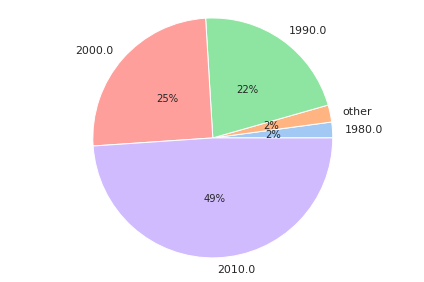

['1910.0',
 '1920.0',
 '1930.0',
 '1940.0',
 '1950.0',
 '1960.0',
 '1970.0',
 'UNKNOWN']

In [70]:
plot_pie_chart(train.drop_duplicates('song_id'), 'decade', 0.7)

country

In [71]:
train.country.unique()

array(['GB', 'US', 'QM', 'TW', 'BE', 'AR', 'CN', 'HK', 'KR', 'JP',
       'UNKNOWN', 'DE', 'CA', 'FR', 'IT', 'NO', 'SE', 'NL', 'DK', 'MY',
       'TC', 'SG', 'UK', 'EM', "['HK' 'TW']", 'ES', 'GM', 'TG', 'CH',
       'TE', 'AU', 'GT', 'PL', 'BR', 'ZA', 'UA', "['CN' 'HK']",
       "['MT' 'TW']", "['CN' 'TW' 'US']", 'GL', 'CY', 'RO', 'IE', 'TH',
       'PT', 'NG', 'FI', 'IN', 'QZ', 'MX', 'VG', 'MT', 'PH',
       "['CN' 'TW']", 'NZ', 'TR', "['TC' 'US']", 'RU', 'EU',
       "['DE' 'QM']", 'TM', 'KZ', 'BX', 'CB', 'CO', 'EG', 'AT', 'AD',
       'BG', 'ID', 'UG', 'GR', 'HR', 'CZ', "['QM' 'US']", 'MH', 'IL',
       'HU', "['BE' 'PT']", 'PR', 'JK', 'ZZ', 'IS', "['GB' 'US']", 'WW',
       'LB', 'MA', 'CL', 'MO', 'KI', 'LV', 'NJ', 'DM', 'MK',
       "['GT' 'TG']", 'AE', 'LU', "['NL' 'US']", "['FR' 'GB']", 'GY',
       'PE', 'IF', 'BZ', "['GB' 'SE' 'US']", 'SK', "['SK' 'US']", 'TP',
       'UD', 'SA', 'PY', 'BK', "['CH' 'JP']", 'EE', 'LT', 'UY', 'JM',
       'UZ', 'SI', 'CM', 'OM', 'BY', 'GD', "['A

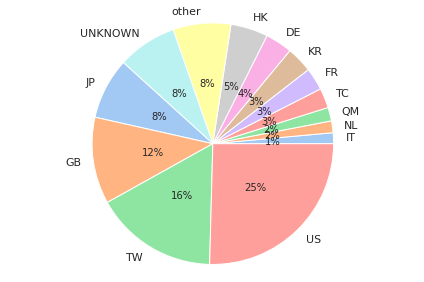

['AD',
 'AE',
 'AR',
 'AT',
 'AU',
 'BE',
 'BG',
 'BK',
 'BR',
 'BX',
 'BY',
 'BZ',
 'CA',
 'CB',
 'CH',
 'CL',
 'CM',
 'CN',
 'CO',
 'CY',
 'CZ',
 'DK',
 'DM',
 'EE',
 'EG',
 'EM',
 'ES',
 'EU',
 'FI',
 'GD',
 'GL',
 'GM',
 'GN',
 'GR',
 'GT',
 'GY',
 'HR',
 'HU',
 'ID',
 'IE',
 'IF',
 'IL',
 'IN',
 'IR',
 'IS',
 'JK',
 'JM',
 'KE',
 'KI',
 'KZ',
 'LB',
 'LT',
 'LU',
 'LV',
 'MA',
 'MH',
 'MK',
 'MO',
 'MT',
 'MX',
 'MY',
 'NG',
 'NJ',
 'NO',
 'NZ',
 'OM',
 'PE',
 'PH',
 'PL',
 'PR',
 'PT',
 'PY',
 'QZ',
 'RO',
 'RS',
 'RU',
 'SA',
 'SE',
 'SG',
 'SI',
 'SK',
 'TE',
 'TG',
 'TH',
 'TM',
 'TP',
 'TR',
 'UA',
 'UD',
 'UG',
 'UK',
 'UY',
 'UZ',
 'VG',
 'WW',
 'YW',
 'ZA',
 'ZZ',
 "['AU' 'US']",
 "['BE' 'PT']",
 "['CH' 'JP']",
 "['CN' 'HK']",
 "['CN' 'TW' 'US']",
 "['CN' 'TW']",
 "['DE' 'GB']",
 "['DE' 'QM']",
 "['FR' 'GB']",
 "['GB' 'SE' 'US']",
 "['GB' 'US']",
 "['GT' 'TG']",
 "['HK' 'TW']",
 "['MT' 'TW']",
 "['NL' 'US']",
 "['PH' 'US']",
 "['QM' 'US']",
 "['SK' 'US']",
 "['TC' 'US']"]

In [74]:
plot_pie_chart(train.drop_duplicates('song_id'), 'country', 0.9)

## Ratios

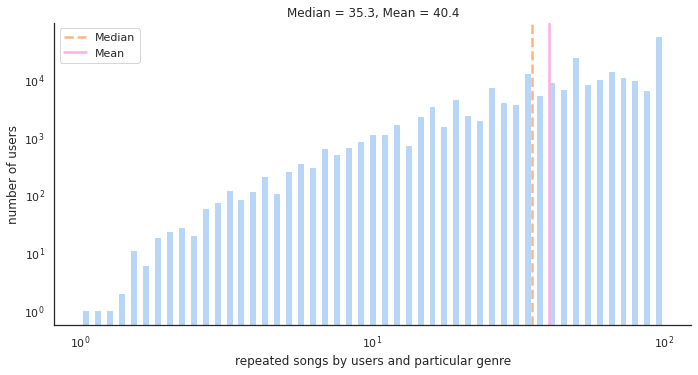

In [84]:
plot_bar_chart(train, 'genre_first_ratio', ['msno', 'genre_first'], 'repeated songs by users and particular genre', 'number of users')

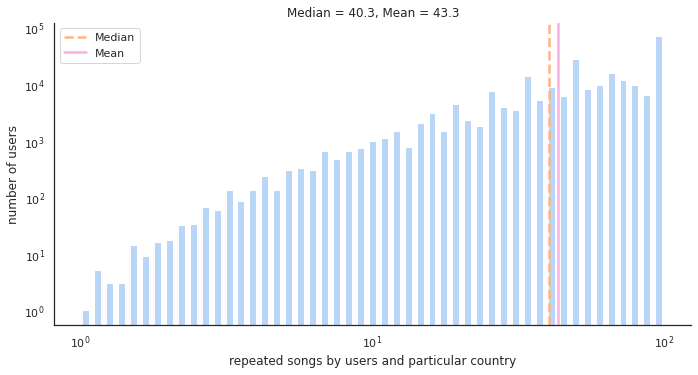

In [83]:
plot_bar_chart(train, 'country_ratio', ['msno', 'country'], 'repeated songs by users and particular country', 'number of users')

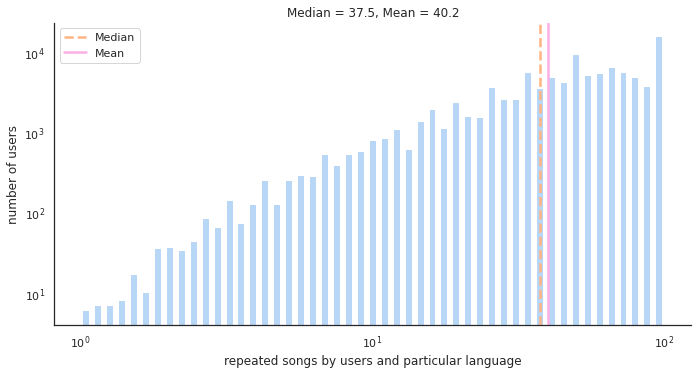

In [82]:
plot_bar_chart(train, 'language_ratio', ['msno', 'language'], 'repeated songs by users and particular language', 'number of users')

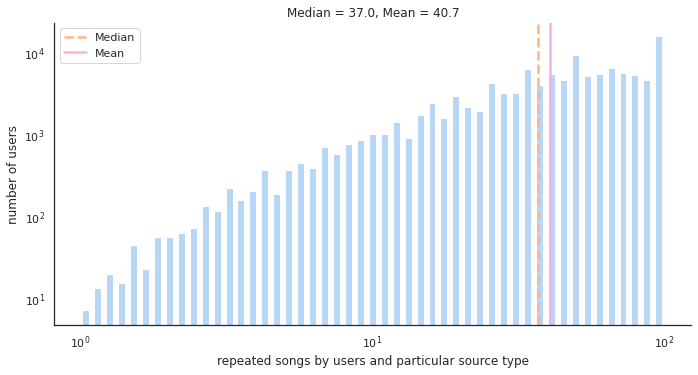

In [86]:
plot_bar_chart(train, 'source_type_ratio', ['msno', 'source_type'], 'repeated songs by users and particular source type', 'number of users')

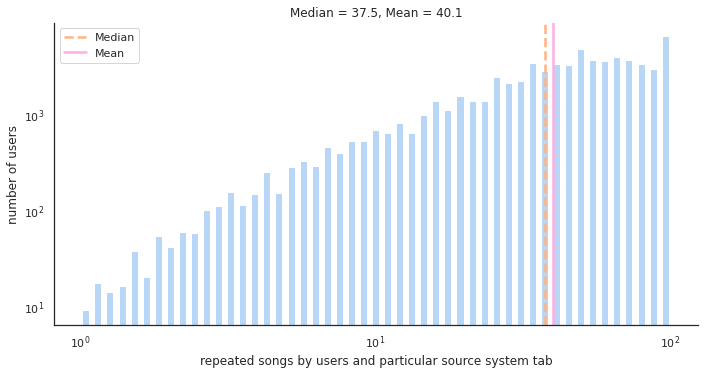

In [87]:
plot_bar_chart(train, 'source_system_tab_ratio', ['msno', 'source_system_tab'], 'repeated songs by users and particular source system tab', 'number of users')

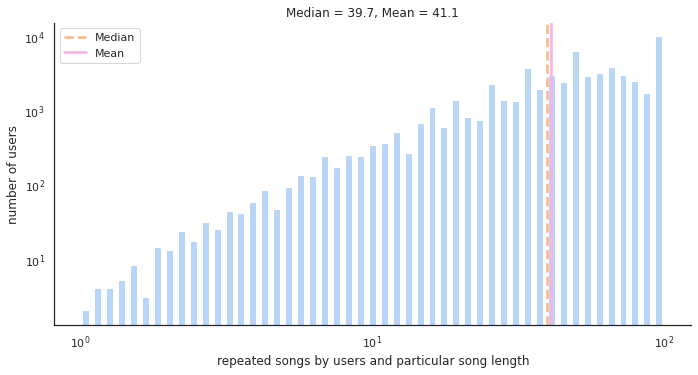

In [88]:
plot_bar_chart(train, 'song_length_cat_ratio', ['msno', 'song_length_cat'], 'repeated songs by users and particular song length', 'number of users')

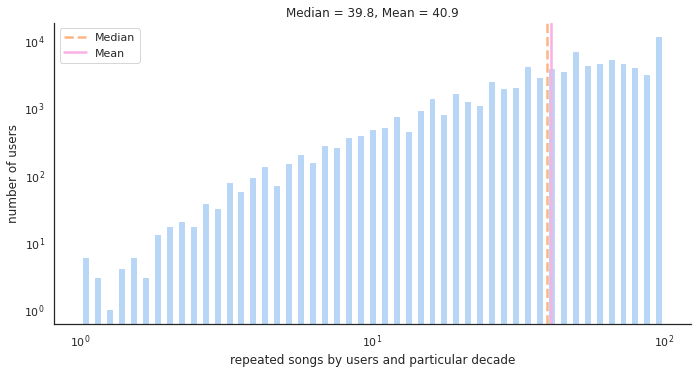

In [89]:
plot_bar_chart(train, 'decade_ratio', ['msno', 'decade'], 'repeated songs by users and particular decade', 'number of users')

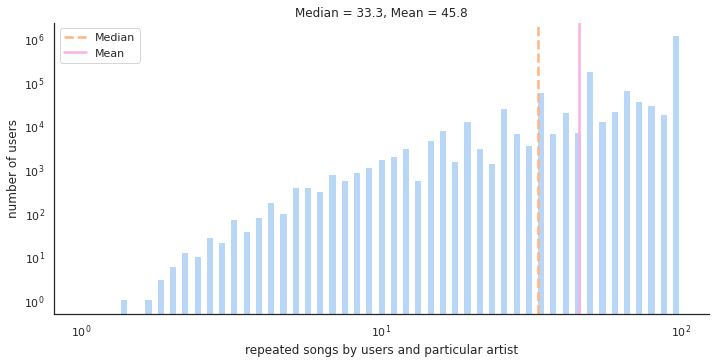

In [91]:
plot_bar_chart(train, 'artist_name_ratio', ['msno', 'artist_name'], 'repeated songs by users and particular artist', 'number of users')

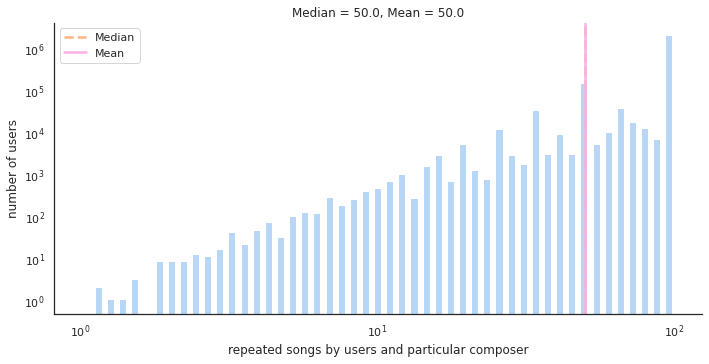

In [92]:
plot_bar_chart(train, 'composer_ratio', ['msno', 'composer'], 'repeated songs by users and particular composer', 'number of users')

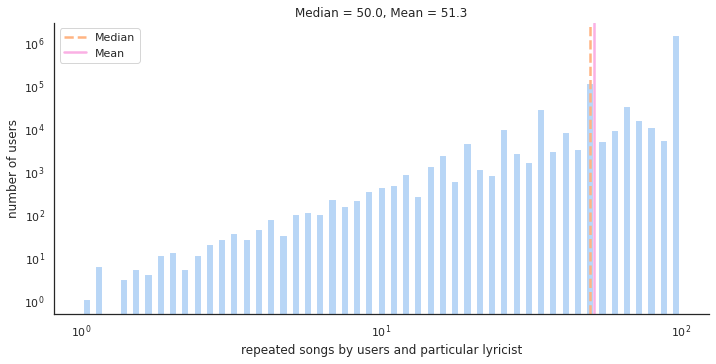

In [93]:
plot_bar_chart(train, 'lyricist_ratio', ['msno', 'lyricist'], 'repeated songs by users and particular lyricist', 'number of users')

## Heatmap

In [ ]:
corr_matrix=train.corr()

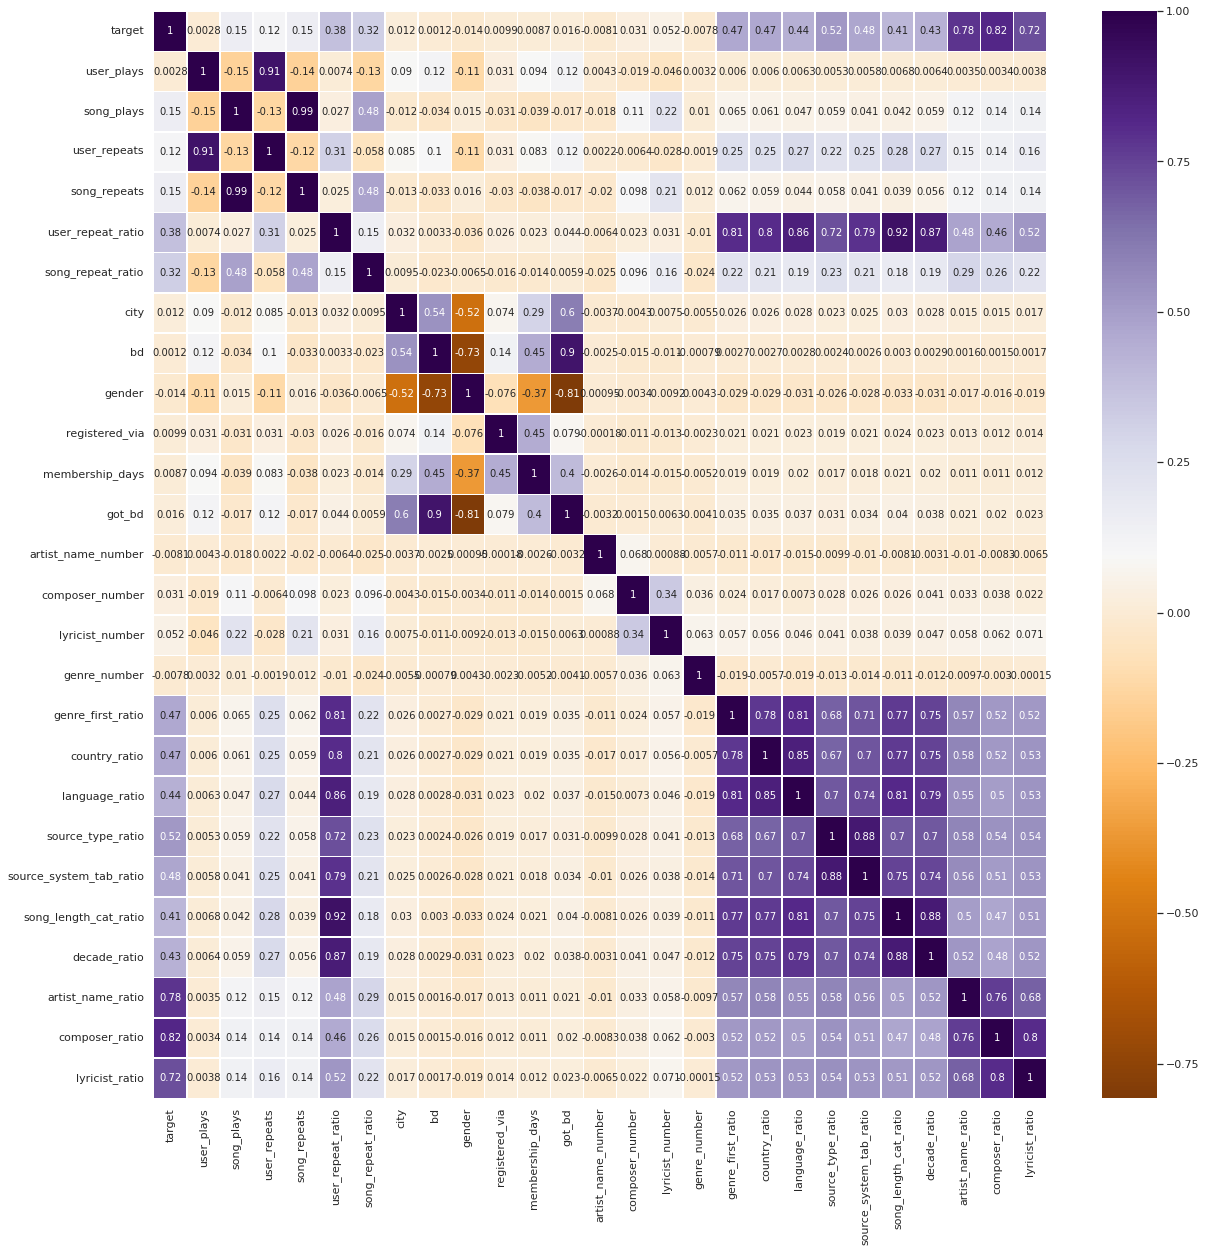

In [98]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, cmap='PuOr', annot=True, linewidths=.5)